# Autoencoder for denoising images



An autoencoder is a type of neural network used to learn efficient features and characteristic patterns of unlabeled data (unsupervised learning), 
through encoding and decoding the input data of the network.
The autoencoder learns a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore insignificant data, like noise.
For this case, will be used the Fashion MNist set and will be applied Gaussian noise  through a cv2 filter to 'blur' the images.
Is to be expected that, at the output of the autoencoder, get the images without noise.


In [23]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.utils import plot_model

In [4]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train, X_test = X_train/255, X_test/255 #Normalize pixels

4431872/4422102 [==============================] - 0s 0us/step


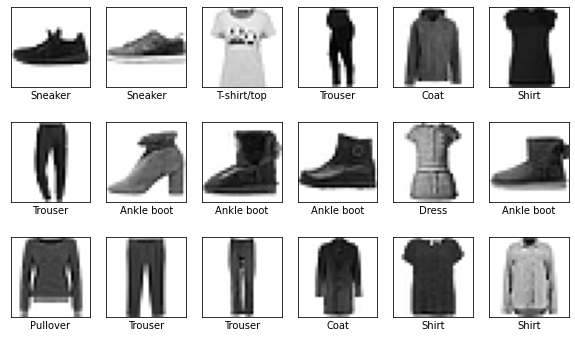

In [6]:
#Examples 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    j = np.random.randint(0,len(X_train))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[j], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[j]])
plt.show()

In [7]:
#Apply Gaussian Noise function
def gaussian_noise(X):
    result = []
    for x in X:
        noisy = cv2.GaussianBlur(x, (3, 3), 0)
        noisy = np.clip(noisy, 0, 1)
        result.append(noisy)
    return np.array(result)

In [8]:
noisy_train = gaussian_noise(X_train)
noisy_test = gaussian_noise(X_test)

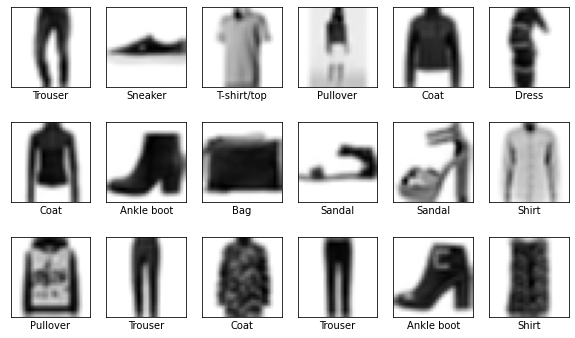

In [9]:
#Noisy examples
plt.figure(figsize=(10,6))
for i in range(18):
    plt.subplot(3,6,i+1)
    j = np.random.randint(0,len(X_train))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_train[j], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[y_train[j]])
plt.show()

#### Building the model

In [19]:
#autoencoder
autoencoder=Sequential()
#encoder
autoencoder.add(Conv2D(filters=16,kernel_size=3,strides=2,padding='same',input_shape=(28,28,1)))
autoencoder.add(Conv2D(filters=8,kernel_size=3,strides=2,padding='same'))
autoencoder.add(Conv2D(filters=8,kernel_size=1,strides=1,padding='same'))
#decoder
autoencoder.add(Conv2DTranspose(filters=8,kernel_size=3,strides=2,padding='same'))
autoencoder.add(Conv2DTranspose(filters=1,kernel_size=3,strides=2,activation='sigmoid',padding='same'))

In [20]:
autoencoder.compile(loss='binary_crossentropy',optimizer='Adam')
autoencoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 8)           72        
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 8)        584       
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 28, 28, 1)        73        
 ranspose)                                                       
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-traina

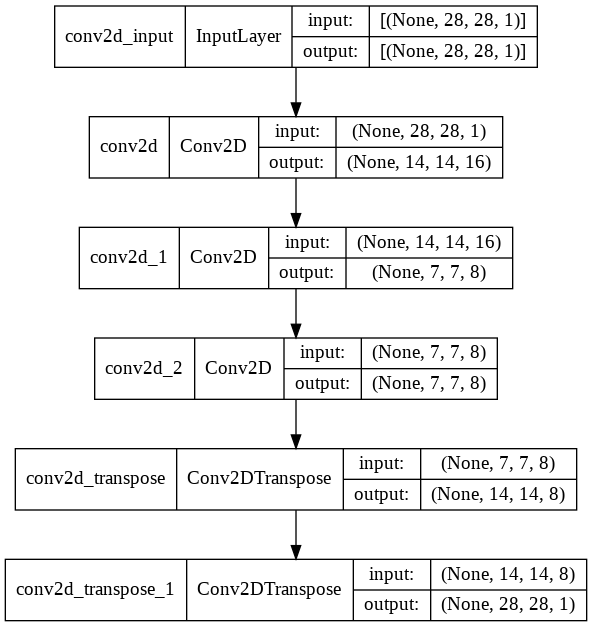

In [16]:
plot_model(autoencoder, show_shapes=True)

In [17]:
#keras will automatically stop training the model based on a on non-reduction 
#of the loss function on the validation data during the model.fit.
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#patience indicates the number of epochs to be done after keras detects a 
#non-reduction in loss function in validation data 


In [21]:
autoencoder.fit(noisy_train.reshape(-1,28,28,1),X_train.reshape(-1,28,28,1),epochs=50, batch_size=50, callbacks=[early_stop],validation_data=(noisy_test.reshape(-1,28,28,1),X_test.reshape(-1,28,28,1)))


Epoch 1/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.3177 - val_loss: 0.2854
Epoch 2/50
1200/1200 [==============================] - 19s 15ms/step - loss: 0.2796 - val_loss: 0.2797
Epoch 3/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2754 - val_loss: 0.2758
Epoch 4/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2721 - val_loss: 0.2729
Epoch 5/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2703 - val_loss: 0.2720
Epoch 6/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2697 - val_loss: 0.2715
Epoch 7/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2691 - val_loss: 0.2708
Epoch 8/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2683 - val_loss: 0.2701
Epoch 9/50
1200/1200 [==============================] - 19s 16ms/step - loss: 0.2679 - val_loss: 0.2700
Epoch 10/50
1200/1200 [==============================] - 19s 16m

In [24]:
loss_df=pd.DataFrame(autoencoder.history.history)

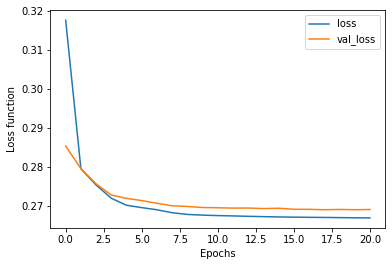

In [26]:
loss_df.plot(xlabel='Epochs',ylabel='Loss function')

In [37]:
# get samples to show
def samples(X, n):
    temp = random.sample(range(len(X)), n)
    result = X[temp]
    return result, temp

In [30]:
n = 15
fashion_ori, temp = samples(X_test, n)
blur = noisy_test[temp]
preds = autoencoder.predict(blur.reshape(-1, 28, 28, 1))
preds = preds.reshape(-1, 28, 28)

Original Images


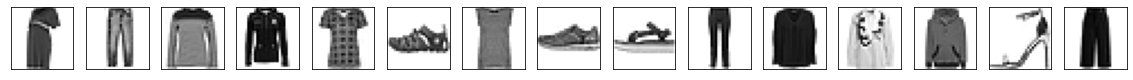

Blurred Images


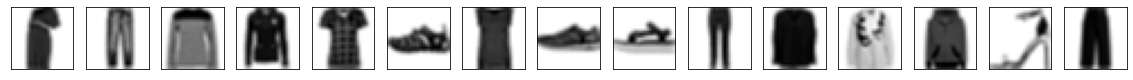

Encoded/Decoded Images


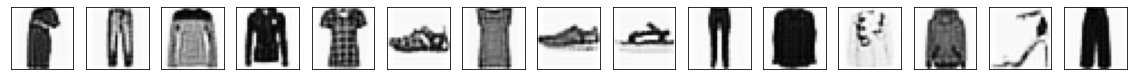

In [35]:
plt.figure(figsize = (20, 20))
print('Original Images')
for i in range(n):
    plt.subplot(1, n, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_ori[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize = (20, 20))
print('Blurred Images')
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i], cmap=plt.cm.binary)
plt.show()

plt.figure(figsize = (20, 20))
print('Encoded/Decoded Images')
for i in range(n):
    plt.subplot(1, n, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i], cmap=plt.cm.binary)
plt.show()